# MIDI Music Generation - Generate

Generate piano music using a trained model.

**Requirements:** Trained model at `midi_data/best_model.pt`  
**Output:** Generated MIDI files in `midi_data/generated/`

## 1. Setup

In [1]:
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from midi_utils import (
    MIDI_CONFIG, NUM_PITCHES, SEQUENCE_LENGTH, SEED,
    get_device, load_model,
    midi_to_piano_roll, piano_roll_to_midi,
    play_piano_roll, play_midi_file,
    generate_music, create_random_seed
)

random.seed(SEED)
np.random.seed(SEED)

DEVICE = get_device()

DATA_DIR = Path("./midi_data")
OUTPUT_DIR = DATA_DIR / "generated"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

Using Apple Silicon MPS


## 2. Load Trained Model

In [2]:
MODEL_PATH = DATA_DIR / "best_model.pt"
MODEL_TYPE = "mamba"  # Must match training

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"No model found at {MODEL_PATH}. Run midi_training.ipynb first!")

model = load_model(MODEL_PATH, model_type=MODEL_TYPE, device=DEVICE)

Loaded mamba model from epoch 3
  Validation loss: 0.0279


## 3. Generate Music

In [3]:
# Generation parameters
DURATION_SECONDS = 30
TEMPERATURE = 0.8  # Lower=coherent, Higher=creative

num_frames = int(DURATION_SECONDS * MIDI_CONFIG["fs"])

# Create a random seed
seed = create_random_seed(SEQUENCE_LENGTH, NUM_PITCHES)

print(f"Generating {DURATION_SECONDS}s of music (temperature={TEMPERATURE})...")
generated = generate_music(model, seed, num_frames, temperature=TEMPERATURE, device=DEVICE)
print(f"Generated shape: {generated.shape}")

Generating 30s of music (temperature=0.8)...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

Generated shape: (544, 88)


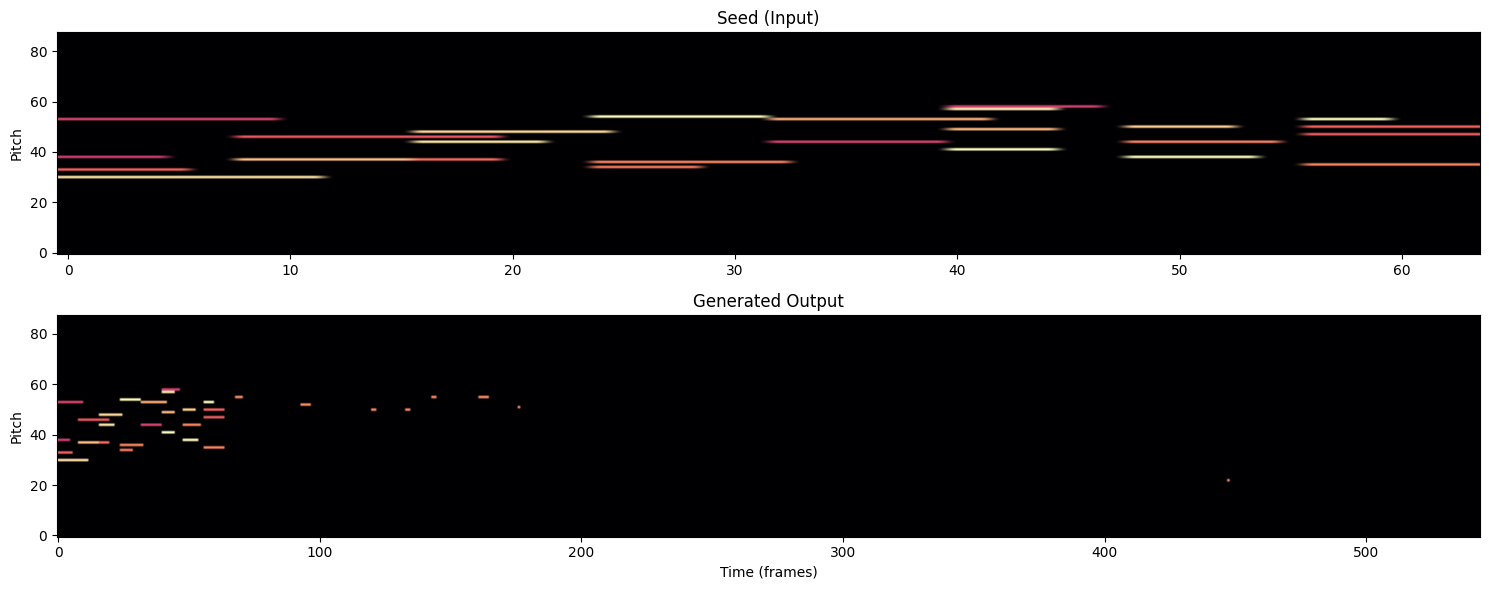

In [4]:
# Visualize
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].imshow(seed.T, aspect='auto', origin='lower', cmap='magma')
axes[0].set_title('Seed (Input)')
axes[0].set_ylabel('Pitch')

axes[1].imshow(generated.T, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title('Generated Output')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Pitch')

plt.tight_layout()
plt.show()

## 4. Play Generated Music

In [5]:
# Play the generated portion only (skip seed)
print(f"Playing generated music ({DURATION_SECONDS}s)...")
generated_only = generated[SEQUENCE_LENGTH:]
play_piano_roll(generated_only, MIDI_CONFIG)

Playing generated music (30s)...


In [6]:
# Play full output (seed + generated)
print("Playing full output (seed + generated)...")
play_piano_roll(generated, MIDI_CONFIG)

Playing full output (seed + generated)...


## 5. Export to MIDI

In [7]:
output_path = OUTPUT_DIR / "generated_music.mid"
piano_roll_to_midi(generated, MIDI_CONFIG, output_path)
print(f"Saved to: {output_path}")

Saved to: midi_data/generated/generated_music.mid


## 6. Explore Different Temperatures

In [8]:
temperatures = [0.5, 0.8, 1.0, 1.2]

for temp in temperatures:
    print(f"\nGenerating with temperature {temp}...")
    seed = create_random_seed()
    gen = generate_music(model, seed, num_frames, temperature=temp, device=DEVICE)
    
    output_path = OUTPUT_DIR / f"generated_temp_{temp}.mid"
    piano_roll_to_midi(gen, MIDI_CONFIG, output_path)
    print(f"  Saved: {output_path.name}")

print(f"\nAll files saved to: {OUTPUT_DIR}")


Generating with temperature 0.5...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

  Saved: generated_temp_0.5.mid

Generating with temperature 0.8...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

  Saved: generated_temp_0.8.mid

Generating with temperature 1.0...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

  Saved: generated_temp_1.0.mid

Generating with temperature 1.2...


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

  Saved: generated_temp_1.2.mid

All files saved to: midi_data/generated


## 7. Generate from MIDI Seed (Optional)

Use an existing MIDI file as the seed for generation.

In [9]:
# Load a MIDI file as seed
# NOTE: Use SEQUENCE_LENGTH (64 frames = 4 seconds) to match training

seed_midi_path = DATA_DIR / "adl-piano-midi/Classical/American Modern Classical/Joseph Lamb/Contentment Rag.mid"

# Reload module to get latest changes (trim_silence fix)
import importlib
import midi_utils
importlib.reload(midi_utils)
from midi_utils import midi_to_piano_roll, generate_music, piano_roll_to_midi, play_piano_roll, SEQUENCE_LENGTH

seed_roll = midi_to_piano_roll(seed_midi_path, MIDI_CONFIG)
if seed_roll is not None:
    print(f"Full piano roll shape: {seed_roll.shape}")
    print(f"First frame has notes: {seed_roll[0].sum() > 0}")  # Verify no leading silence
    
    # Use SEQUENCE_LENGTH (64 frames) to match training, not 256!
    seed = seed_roll[:SEQUENCE_LENGTH]
    print(f"Seed shape: {seed.shape} ({SEQUENCE_LENGTH / MIDI_CONFIG['fs']:.1f} seconds)")
    
    generated = generate_music(model, seed, num_frames, temperature=1.2, device=DEVICE)
    
    output_path = OUTPUT_DIR / "generated_from_midi_seed.mid"
    piano_roll_to_midi(generated, MIDI_CONFIG, output_path)
    print(f"Saved to: {output_path}")
    
    # Play ONLY the generated part (skip seed)
    print(f"\nPlaying GENERATED part only ({num_frames / MIDI_CONFIG['fs']:.1f} seconds):")
    generated_only = generated[SEQUENCE_LENGTH:]
    play_piano_roll(generated_only, MIDI_CONFIG)

Full piano roll shape: (872, 88)
First frame has notes: True
Seed shape: (64, 88) (4.0 seconds)


Generating:   0%|          | 0/480 [00:00<?, ?it/s]

Saved to: midi_data/generated/generated_from_midi_seed.mid

Playing GENERATED part only (30.0 seconds):


In [10]:
# Compare: Original seed vs Generated continuation
from IPython.display import display, HTML

print("=== SEED (original MIDI, 4 seconds) ===")
display(play_piano_roll(seed, MIDI_CONFIG))

print("\n=== GENERATED (model output, 30 seconds) ===")
display(play_piano_roll(generated_only, MIDI_CONFIG))

print("\n=== FULL OUTPUT (seed + generated) ===")
display(play_piano_roll(generated, MIDI_CONFIG))

=== SEED (original MIDI, 4 seconds) ===



=== GENERATED (model output, 30 seconds) ===



=== FULL OUTPUT (seed + generated) ===


## Tips

**Temperature guide:**
- `0.5` - Very coherent, possibly repetitive
- `0.8` - Balanced (recommended)
- `1.0` - More creative
- `1.2+` - Experimental, may be chaotic

**For better results:**
- Train for more epochs (50-100+)
- Use full dataset (remove MAX_FILES_PER_SPLIT limit)
- Try different seeds